In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dask import dataframe as dd

In [2]:
comments = pd.read_csv('comments.csv', header = None)
users_comments = pd.read_csv('users_comments.csv', header = None)

In [3]:
comments.columns = ['cid','subreddit', 'created_utc', 'karma']
users_comments.columns = ['author', 'cid']

In [4]:
# join comments and users_comments tables
cuc = pd.merge(comments, users_comments, on='cid')

### Count of Karma by Author/User

In [5]:
karma_by_author = pd.DataFrame(cuc.groupby('author')['karma'].sum()).reset_index()

In [6]:
karma_by_author = karma_by_author.sort_values('karma')
karma_by_author

,author,karma
24069,FastOCR18,-3187
133478,ginmhilleadh,-2713
172651,mikepunk,-1369
64772,SlowOCR_13,-980
159561,krakow057,-827
...,...,...
86469,ani625,16368
133025,ggggbabybabybaby,18172
55898,ProbablyHittingOnYou,18444
86101,andrewsmith1986,29956


In [7]:
top_5_sum_author = karma_by_author.sort_values(by = 'karma', ascending = False).head()
bottom_5_sum_author = karma_by_author.sort_values(by = 'karma').head()

In [8]:
top_5_sum_author.set_index('author')

,karma
author,
Sure_Ill_Draw_That,65288
andrewsmith1986,29956
ProbablyHittingOnYou,18444
ggggbabybabybaby,18172
ani625,16368


In [9]:
bottom_5_sum_author.set_index('author')

,karma
author,
FastOCR18,-3187
ginmhilleadh,-2713
mikepunk,-1369
SlowOCR_13,-980
krakow057,-827


In [10]:
# karma_by_author = pd.DataFrame(karma_by_author).reset_index()
karma_by_author['bin'] = pd.qcut(karma_by_author['karma'], q = 50, duplicates = 'drop')
karma_by_author

,author,karma,bin
24069,FastOCR18,-3187,"(-3187.001, -1.0]"
133478,ginmhilleadh,-2713,"(-3187.001, -1.0]"
172651,mikepunk,-1369,"(-3187.001, -1.0]"
64772,SlowOCR_13,-980,"(-3187.001, -1.0]"
159561,krakow057,-827,"(-3187.001, -1.0]"
...,...,...,...
86469,ani625,16368,"(714.0, 65288.0]"
133025,ggggbabybabybaby,18172,"(714.0, 65288.0]"
55898,ProbablyHittingOnYou,18444,"(714.0, 65288.0]"
86101,andrewsmith1986,29956,"(714.0, 65288.0]"


<AxesSubplot:title={'center':'Count of Users by Karma (Binned)'}, xlabel='karma bins', ylabel='count of users in bin'>

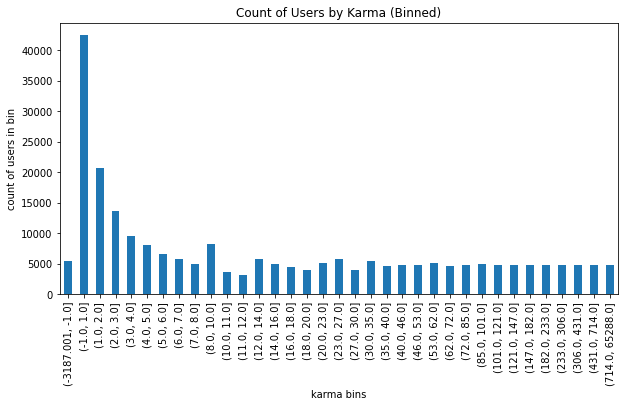

In [11]:
bins = karma_by_author.groupby('bin')['karma'].count()
bins.plot(kind = 'bar', title = 'Count of Users by Karma (Binned)', xlabel = 'karma bins', ylabel = 'count of users in bin', figsize = (10, 5))

### Average Karma for Comments made by Authors/Users

In [12]:
karma_by_author_avg = pd.DataFrame(cuc.groupby('author')['karma'].mean()).reset_index()

In [13]:
top_5_avg_author = karma_by_author_avg.sort_values(by = 'karma', ascending = False).head()
bottom_5_avg_author = karma_by_author_avg.sort_values(by = 'karma').head()

In [14]:
top_5_avg_author.set_index('author')

,karma
author,
barehandhunter,2232.0
amativus,1738.0
The_Joke_Explained,1596.0
-captain-hindsight-,1293.0
Lovesnoveltyaccounts,1284.0


In [15]:
bottom_5_avg_author.set_index('author')

,karma
author,
breeedeeer,-113.0
asdffsd,-78.0
wikimedia,-65.0
AttackingHobo,-51.6
beast_of_a_priest,-47.0


<AxesSubplot:title={'center':'Average Karma for Comments Made by Users (Binned)'}, xlabel='average karma', ylabel='count of users in bin'>

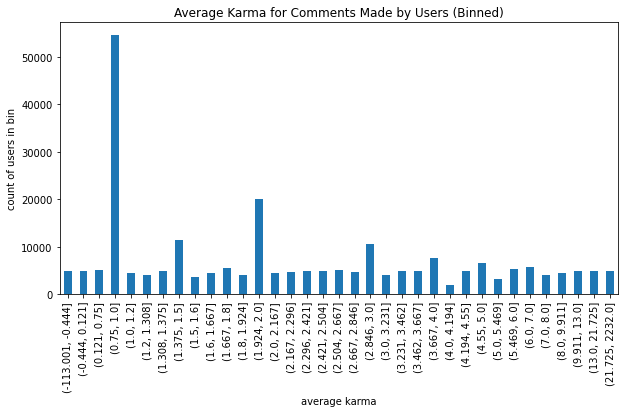

In [16]:
karma_by_author_avg['bin'] = pd.qcut(karma_by_author_avg['karma'], q = 50, duplicates = 'drop')
avg_author_bins = karma_by_author_avg.groupby('bin')['karma'].count()
avg_author_bins.plot(kind = 'bar', title = 'Average Karma for Comments Made by Users (Binned)', xlabel = 'average karma', ylabel = 'count of users in bin', figsize = (10, 5))

### Average Karma For a Comment by Subreddit

In [17]:
karma_by_subreddit = pd.DataFrame(cuc.groupby('subreddit')['karma'].mean()).reset_index()

In [18]:
top_5_avg_subreddit = karma_by_subreddit.sort_values(by = 'karma', ascending = False).head()
bottom_5_avg_subreddit = karma_by_subreddit.sort_values(by = 'karma').head()

In [19]:
top_5_avg_subreddit.set_index('subreddit')

,karma
subreddit,
DateRape,27.606780
republicans,23.000000
ectalProlapse,14.000000
VOTE4DICKOFTHEYEAR,12.104167
redditzine,12.000000


In [20]:
bottom_5_avg_subreddit.set_index('subreddit')

,karma
subreddit,
CompulsiveDownvoters,-5.000000
crybaby,-4.166667
coke,-2.000000
NaziHunting,-1.086957
PornStars,-1.000000


<AxesSubplot:title={'center':'Average Karma for a Comment by Subreddit (Binned)'}, xlabel='average karma', ylabel='count of subreddits in bin'>

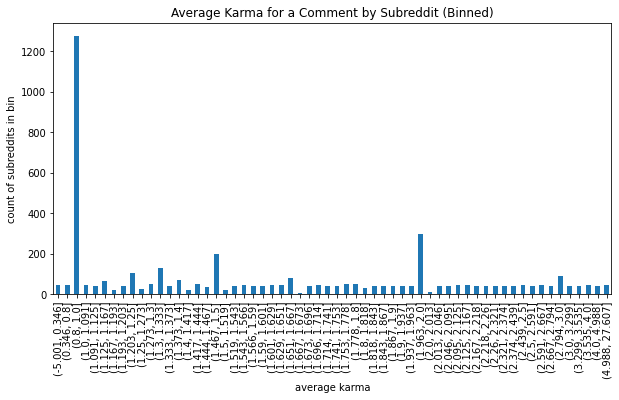

In [21]:
karma_by_subreddit['bin'] = pd.qcut(karma_by_subreddit['karma'], q = 100, duplicates = 'drop')
subreddit_bins = karma_by_subreddit.groupby('bin')['karma'].count()
subreddit_bins.plot(kind = 'bar', title = 'Average Karma for a Comment by Subreddit (Binned)', xlabel = 'average karma', ylabel = 'count of subreddits in bin', figsize = (10, 5))